## **Library**

In [ ]:
import os
import logging
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import Dataset

In [ ]:
import timm

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preparation**

In [33]:
class ISIC_Dataset(Dataset):
    def __init__(self, imgs_dir, masks_dir):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.imgs_name = [file_name for file_name in os.listdir(imgs_dir) if file_name.endswith('.jpg')]
        self.imgs_path = [os.path.join(self.imgs_dir, file_name) for file_name in self.imgs_name]
        self.masks_path = [os.path.join(self.masks_dir, file_name[:-4] + '_segmentation.png') for file_name in self.imgs_name]


    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, index):
        # Load image and mask
        image = Image.open(self.imgs_path[index]).convert('RGB')
        mask = Image.open(self.masks_path[index]).convert('L')

        # Resize images and masks
        image = image.resize((224, 224), Image.BILINEAR)
        mask = mask.resize((224, 224), Image.NEAREST)

        # Convert to numpy array and normalize
        image = np.asarray(image) / 255.0
        mask = np.asarray(mask) / 255.0

        # # Convert mask to binary format
        # mask = (mask > 0.5).astype(np.int8)


        # Convert to torch tensors
        image = torch.tensor(image, dtype= torch.float32).permute(2, 0, 1) # Channel first
        mask = torch.tensor(mask).long().contiguous() #.unsqueeze(0) # Add channel dimension

        return {'image': image, 'mask': mask}

In [ ]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -q -/.kaggle
!cp kaggle.json -/.kaggle

mkdir: invalid option -- 'q'
Try 'mkdir --help' for more information.
cp: invalid option -- '/'
Try 'cp --help' for more information.


In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isic2018-challenge-task1-data-segmentation


In [34]:
dir_img = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
dir_mask = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'
val_percent = 0.2

dataset = ISIC_Dataset(dir_img, dir_mask)

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

In [35]:
print(len(train_set))  # Kiểm tra số lượng mẫu trong train_set
print(len(val_set))    # Kiểm tra số lượng mẫu trong val_set

2076
518


In [36]:
batch_size = 8
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch['image'][0].shape, batch['mask'][0].shape

(torch.Size([3, 224, 224]), torch.Size([224, 224]))

In [ ]:
np.max(np.array(batch['mask'][0]))

np.int64(1)

In [ ]:
# # Data
# file_path = '/content/drive/MyDrive/Train/Data_UNet/ISIC2018_train.npz'
# data = np.load(file_path)
# x, y = data["image"], data["mask"]
# test_size = int((20/100)*x.shape[0])
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=257)
# del x, y, data

In [ ]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2076, 192, 256, 3), (2076, 192, 256), (518, 192, 256, 3), (518, 192, 256))

In [ ]:
# # Tạo DataFrame để lưu số lượng mẫu của từng lớp
# columns = ['0','1']
# df = pd.DataFrame(columns=columns)

# # Đếm số lượng mẫu trong y_train
# _, counts =  np.unique(y_train, return_counts=True)
# conts_dict = dict(zip(columns, counts))

# # Lưu số lượng mẫu của từng lớp vào DataFrame
# df = pd.concat([df, pd.DataFrame([conts_dict])], ignore_index=True)

# # Tính tổng số lượng mẫu cho từng lớp
# label_0 = df['0'].sum()
# label_1 = df['1'].sum()
# total_labels = label_0 + label_1
# n_classes = 2

# # Tính trọng số
# wt0 = round((total_labels/(n_classes*label_0)), 2)
# wt1 = round((total_labels/(n_classes*label_1)), 2)

# class_weight = [wt0, wt1]
# # 0.64 2.35

In [ ]:
# class RandomCrop(transforms.RandomResizedCrop):
#     def __call__(self, imgs):
#         i, j, h, w = self.get_params(imgs[0], self.scale, self.ratio)
#         for imgCount in range(len(imgs)):
#             imgs[imgCount] = transforms.functional.resized_crop(imgs[imgCount], i, j, h, w, self.size, self.interpolation)
#         return imgs

# class ISICLoader(Dataset):
#     def __init__(self, images, masks,
#                  transform=True, typeData = "train"):
#         self.transform = transform if typeData == "train" else False  # augment data bool
#         self.typeData = typeData
#         self.images = images
#         self.masks = masks
#     def __len__(self):
#         return len(self.images)

#     # Xoay ảnh
#     def rotate(self, image, mask, degrees=(-15,15), p=0.5):
#         if torch.rand(1) < p:
#             degree = np.random.uniform(*degrees)
#             image = image.rotate(degree, Image.NEAREST) # Dùng nội suy NEAREST để tránh thay đổi giá trị của pixel
#             mask = mask.rotate(degree, Image.NEAREST)
#         return image, mask

#     # Lật ngang ảnh
#     def horizontal_flip(self, image, mask, p=0.5):
#         if torch.rand(1) < p:
#             image = image.transpose(Image.FLIP_LEFT_RIGHT)
#             mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
#         return image, mask

#     # Lật dọc ảnh
#     def vertical_flip(self, image, mask, p=0.5):
#         if torch.rand(1) < p:
#             image = image.transpose(Image.FLIP_TOP_BOTTOM)
#             mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
#         return image, mask

#     # Cắt ngẫu nhiên
#     def random_resized_crop(self, image, mask, p=0.1):
#         if torch.rand(1) < p:
#             image, mask = RandomCrop((192, 256), scale=(0.8, 0.95))([image, mask])
#         return image, mask

#     # Augmentation
#     def augment(self, image, mask):
#         image, mask = self.random_resized_crop(image, mask)
#         image, mask = self.rotate(image, mask)
#         image, mask = self.horizontal_flip(image, mask)
#         image, mask = self.vertical_flip(image, mask)
#         return image, mask

#     # Trả về dữ liệu
#     def __getitem__(self, idx):
#         image = Image.fromarray(self.images[idx])
#         mask = Image.fromarray(self.masks[idx])
#     ####################### augmentation data ##############################
#         if self.transform:
#             image, mask = self.augment(image, mask)
#         image = transforms.ToTensor()(image)
#         mask = np.asarray(mask, np.int64)
#         mask = torch.from_numpy(mask[np.newaxis])
#         return image, mask

In [ ]:
# train_dataset = DataLoader(ISICLoader(X_train, y_train), batch_size=4, pin_memory=True, shuffle=True, num_workers=2, drop_last=True, prefetch_factor = 8)
# test_dataset = DataLoader(ISICLoader(X_test, y_test, typeData="test"), batch_size=1, num_workers=2, prefetch_factor=16)

In [ ]:
# batch = next(iter(train_dataset))

## **UNet**

In [38]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convblock(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [39]:
class TransUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=False, img_size=28, patch_size=7):
        super(TransUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.img_size = img_size
        self.patch_size = patch_size

        # U-Net Encoder
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Encoder(64, 128)
        self.down2 = Encoder(128, 256)
        self.down3 = Encoder(256, 512)
        factor = 2 if bilinear else 1

        # Vision Transformer (ViT)
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=0, img_size=img_size)
        num_patches = (img_size // patch_size) ** 2  # 4x4 = 16 patches
        self.vit.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, 768) * 0.02)
        self.vit.patch_embed.proj = nn.Conv2d(512, 768, kernel_size=patch_size, stride=patch_size)
        self.vit_head = nn.Conv2d(768, 512, kernel_size=1)

        # Initialize weights
        self._initialize_weights()

        # U-Net Decoder
        self.up1 = Decoder(512, 256 // factor, bilinear)
        self.up2 = Decoder(256, 128 // factor, bilinear)
        self.up3 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)  # 224x224
        x2 = self.down1(x1)  # 112x112
        x3 = self.down2(x2)  # 56x56
        x4 = self.down3(x3)  # 28x28

        b, c, h, w = x4.shape
        x4 = self.vit.patch_embed(x4)
        cls_token = self.vit.cls_token.expand(b, -1, -1)
        x4 = torch.cat((cls_token, x4), dim=1)
        x4 = self.vit.pos_drop(x4 + self.vit.pos_embed)
        for blk in self.vit.blocks:
            x4 = blk(x4)
        x4 = self.vit.norm(x4)
        x4 = x4[:, 1:]  # Remove class token
        x4 = x4.reshape(b, h // self.patch_size, w // self.patch_size, -1).permute(0, 3, 1, 2)
        x4 = self.vit_head(x4)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        from torch.utils.checkpoint import checkpoint

        def checkpointed_forward(module):
            def forward(*args):
                return module(*args)
            return forward

        self.inc = checkpointed_forward(self.inc)
        self.down1 = checkpointed_forward(self.down1)
        self.down2 = checkpointed_forward(self.down2)
        self.down3 = checkpointed_forward(self.down3)
        self.up1 = checkpointed_forward(self.up1)
        self.up2 = checkpointed_forward(self.up2)
        self.up3 = checkpointed_forward(self.up3)
        self.outc = checkpointed_forward(self.outc)
        for i, blk in enumerate(self.vit.blocks):
            self.vit.blocks[i] = checkpointed_forward(blk)
        self.vit.patch_embed = checkpointed_forward(self.vit.patch_embed)
        self.vit_head = checkpointed_forward(self.vit_head)

In [40]:
model = TransUNet(n_channels=3, n_classes=2)
print(model)

TransUNet(
  (inc): ConvBlock(
    (convblock): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): ReLU(inplace=True)
    )
  )
  (down1): Encoder(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (convblock): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Encoder(
    (max

## **Evaluation Metrics**

In [41]:
from torch import Tensor

In [42]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    assert input.size() == target.size()
    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)
    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

def iou_score(input: Tensor, target: Tensor, epsilon: float = 1e-6):
    inter = (input * target).sum(dim=(-1, -2))
    union = input.sum(dim=(-1, -2)) + target.sum(dim=(-1, -2)) - inter
    iou = (inter + epsilon) / (union + epsilon)
    return iou.mean()

def precision_recall_f1(input: Tensor, target: Tensor, epsilon: float = 1e-6):
    tp = (input * target).sum(dim=(-1, -2))
    fp = input.sum(dim=(-1, -2)) - tp
    fn = target.sum(dim=(-1, -2)) - tp
    precision = (tp + epsilon) / (tp + fp + epsilon)
    recall = (tp + epsilon) / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return precision.mean(), recall.mean(), f1.mean()

In [43]:
@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou = 0
    precision = 0
    recall = 0
    f1 = 0

    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, desc='Validation round'):
            image, mask_true = batch['image'], batch['mask']
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)
            mask_pred = net(image)

            mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
            mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()

            dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)
            iou += iou_score(mask_pred[:, 1:], mask_true[:, 1:])
            prec, rec, f1_score = precision_recall_f1(mask_pred[:, 1:], mask_true[:, 1:])
            precision += prec
            recall += rec
            f1 += f1_score

    net.train()
    metrics = {
        'Dice': dice_score / max(num_val_batches, 1),
        'IoU': iou / max(num_val_batches, 1),
        'Precision': precision / max(num_val_batches, 1),
        'Recall': recall / max(num_val_batches, 1),
        'F1': f1 / max(num_val_batches, 1)
    }
    return metrics

In [ ]:
# def sigmoid_output_to_binary(pred, threshold=0.5):
#     return (torch.sigmoid(pred) > threshold).float()

# def dice_coefficient(pred, target, epsilon=1e-6):
#     pred = pred.contiguous().view(-1)
#     target = target.contiguous().view(-1)
#     intersection = (pred * target).sum()
#     return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# def iou_score(pred, target, epsilon=1e-6):
#     pred = pred.contiguous().view(-1)
#     target = target.contiguous().view(-1)
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum() - intersection
#     return (intersection + epsilon) / (union + epsilon)

# def precision_score(pred, target, epsilon=1e-6):
#     pred = pred.contiguous().view(-1)
#     target = target.contiguous().view(-1)
#     tp = (pred * target).sum()
#     fp = (pred * (1 - target)).sum()
#     return (tp + epsilon) / (tp + fp + epsilon)

# def recall_score(pred, target, epsilon=1e-6):
#     pred = pred.contiguous().view(-1)
#     target = target.contiguous().view(-1)
#     tp = (pred * target).sum()
#     fn = ((1 - pred) * target).sum()
#     return (tp + epsilon) / (tp + fn + epsilon)

# def f1_score(pred, target, epsilon=1e-6):
#     prec = precision_score(pred, target, epsilon)
#     rec = recall_score(pred, target, epsilon)
#     return (2 * prec * rec + epsilon) / (prec + rec + epsilon)


In [ ]:
# import torch
# import torch.nn.functional as F
# from tqdm import tqdm


# @torch.inference_mode()
# def evaluate(net, dataloader, device, amp):
#     net.eval()
#     num_val_batches = len(dataloader)
#     dice_score = 0

#     # iterate over the validation set
#     with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
#         for batch in tqdm(dataloader, desc='Validation round'):
#             image, mask_true = batch['image'], batch['mask']

#             # move images and labels to correct device and type
#             image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
#             mask_true = mask_true.to(device=device, dtype=torch.long)

#             # predict the mask
#             mask_pred = net(image)

#             if net.n_classes == 1:
#                 assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
#                 mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
#                 # compute the Dice score
#                 dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
#             else:
#                 assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
#                 # convert to one-hot format
#                 mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
#                 mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
#                 # compute the Dice score, ignoring background
#                 dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)


#     net.train()
#     return dice_score / max(num_val_batches, 1)

## **Training**

In [31]:
EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 1e-6  # Reduced from 1e-5 to stabilize training
VAL_PERCENT = 0.1
IMG_SCALE = 0.5
AMP = True
WEIGHT_DECAY = 1e-8
MOMENTUM = 0.9  # Adjusted from 0.999 to a more standard value
GRADIENT_CLIPPING = 1.0
SAVE_CHECKPOINT = True
LOAD_MODEL = False
N_CLASSES = 2
BILINEAR = False

dir_img = Path('./data/imgs/')
dir_mask = Path('./data/masks/')
dir_checkpoint = Path('./checkpoints/')

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

model = TransUNet(n_channels=3, n_classes=N_CLASSES, bilinear=BILINEAR)
model = model.to(device=device, memory_format=torch.channels_last)

logging.info(f'Network:\n'
             f'\t{model.n_channels} input channels\n'
             f'\t{model.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if LOAD_MODEL:
    state_dict = torch.load(LOAD_MODEL, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {LOAD_MODEL}')

def train_model(
    model,
    device,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    val_percent=VAL_PERCENT,
    save_checkpoint=SAVE_CHECKPOINT,
    img_scale=IMG_SCALE,
    amp=AMP,
    weight_decay=WEIGHT_DECAY,
    momentum=MOMENTUM,
    gradient_clipping=GRADIENT_CLIPPING
):
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']
                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks)
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )
                    # Debug: Check loss value
                    if torch.isnan(loss):
                        logging.warning(f"NaN loss detected at epoch {epoch}, step {global_step}")
                        break

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item() if not torch.isnan(loss) else 'nan'})

            if torch.isnan(loss):
                logging.error(f"Training stopped due to NaN loss at epoch {epoch}")
                break

            metrics = evaluate(model, val_loader, device, amp)
            scheduler.step(metrics['Dice'])

            logging.info(f'Epoch {epoch}/{epochs} Validation Metrics:')
            logging.info(f'  Dice Score: {metrics["Dice"]:.4f}')
            logging.info(f'  IoU: {metrics["IoU"]:.4f}')
            logging.info(f'  Precision: {metrics["Precision"]:.4f}')
            logging.info(f'  Recall: {metrics["Recall"]:.4f}')
            logging.info(f'  F1 Score: {metrics["F1"]:.4f}')

        if save_checkpoint:
            dir_checkpoint.mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            torch.save(state_dict, dir_checkpoint / f'checkpoint_epoch{epoch}.pth')
            logging.info(f'Checkpoint {epoch} saved!')

try:
    train_model(model=model, device=device)
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! Enabling checkpointing.')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(model=model, device=device)

<ipython-input-31-66b24c96204a>:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
Epoch 5/5: 100%|██████████| 2076/2076 [06:18<00:00,  5.48img/s, loss (batch)=0.393]


In [45]:
import math

In [ ]:
"""## Training"""

EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 1e-6
VAL_PERCENT = 0.1
IMG_SCALE = 0.5
AMP = True
WEIGHT_DECAY = 1e-4  # Tăng weight decay để regularization
MOMENTUM = 0.9
GRADIENT_CLIPPING = 1.0
SAVE_CHECKPOINT = True
LOAD_MODEL = False
N_CLASSES = 2
BILINEAR = False
EARLY_STOPPING_PATIENCE = 3  # Dừng nếu không cải thiện sau 3 epoch

dir_img = Path('./data/imgs/')
dir_mask = Path('./data/masks/')
dir_checkpoint = Path('./checkpoints/')

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

model = TransUNet(n_channels=3, n_classes=N_CLASSES, bilinear=BILINEAR)
model = model.to(device=device, memory_format=torch.channels_last)

logging.info(f'Network:\n'
             f'\t{model.n_channels} input channels\n'
             f'\t{model.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if LOAD_MODEL:
    state_dict = torch.load(LOAD_MODEL, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {LOAD_MODEL}')

def train_model(
    model,
    device,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    val_percent=VAL_PERCENT,
    save_checkpoint=SAVE_CHECKPOINT,
    img_scale=IMG_SCALE,
    amp=AMP,
    weight_decay=WEIGHT_DECAY,
    momentum=MOMENTUM,
    gradient_clipping=GRADIENT_CLIPPING,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
):
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Thay đổi scheduler cố định
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0
    last_batch_loss = float('nan')
    best_val_dice = float('-inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']
                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks)
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )
                    if torch.isnan(loss):
                        logging.warning(f"NaN loss detected at epoch {epoch}, step {global_step}")
                        break

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                last_batch_loss = loss.item() if not torch.isnan(loss) else float('nan')
                logging.info(f'\nFinal Training Loss (last batch): {last_batch_loss:.4f}' if not math.isnan(last_batch_loss) else '\nFinal Training Loss (last batch): nan')

            if torch.isnan(loss):
                logging.error(f"Training stopped due to NaN loss at epoch {epoch}")
                break

            metrics = evaluate(model, val_loader, device, amp)
            scheduler.step()

            logging.info(f'Epoch {epoch}/{epochs} Validation Metrics:')
            logging.info(f'  Dice Score: {metrics["Dice"]:.4f}')
            logging.info(f'  IoU: {metrics["IoU"]:.4f}')
            logging.info(f'  Precision: {metrics["Precision"]:.4f}')
            logging.info(f'  Recall: {metrics["Recall"]:.4f}')
            logging.info(f'  F1 Score: {metrics["F1"]:.4f}')

            # Early stopping
            if metrics['Dice'] > best_val_dice:
                best_val_dice = metrics['Dice']
                patience_counter = 0
                if save_checkpoint:
                    dir_checkpoint.mkdir(parents=True, exist_ok=True)
                    state_dict = model.state_dict()
                    torch.save(state_dict, dir_checkpoint / 'best_checkpoint.pth')
                    logging.info('Best checkpoint saved!')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    logging.info(f'Early stopping triggered after {epoch} epochs')
                    break

        if save_checkpoint:
            dir_checkpoint.mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            torch.save(state_dict, dir_checkpoint / f'checkpoint_epoch{epoch}.pth')
            logging.info(f'Checkpoint {epoch} saved!')

try:
    train_model(model=model, device=device, early_stopping_patience=EARLY_STOPPING_PATIENCE)
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! Enabling checkpointing.')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(model=model, device=device, early_stopping_patience=EARLY_STOPPING_PATIENCE)

<ipython-input-46-01a1095031d7>:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
Epoch 5/5:  76%|███████▌  | 1568/2076 [04:14<01:17,  6.53img/s]

In [32]:
# Final evaluation after training
metrics = evaluate(model, val_loader, device, AMP)

# Print final evaluation results
logging.info('\nFinal Evaluation Metrics:')
logging.info('-' * 60)
logging.info(f"{'Metric':<12} {'Value':<10}")
logging.info('-' * 60)
logging.info(f"{'Dice Score':<12} {metrics['Dice']:.4f}")
logging.info(f"{'IoU':<12} {metrics['IoU']:.4f}")
logging.info(f"{'Precision':<12} {metrics['Precision']:.4f}")
logging.info(f"{'Recall':<12} {metrics['Recall']:.4f}")
logging.info(f"{'F1 Score':<12} {metrics['F1']:.4f}")
logging.info('-' * 60)

# Save final results to file
results_file = 'final_evaluation_results1.txt'
with open(results_file, 'w') as f:
    f.write(f"{'Metric':<12} {'Value':<10}\n")
    f.write('-' * 60 + '\n')
    f.write(f"{'Dice Score':<12} {metrics['Dice']:.4f}\n")
    f.write(f"{'IoU':<12} {metrics['IoU']:.4f}\n")
    f.write(f"{'Precision':<12} {metrics['Precision']:.4f}\n")
    f.write(f"{'Recall':<12} {metrics['Recall']:.4f}\n")
    f.write(f"{'F1 Score':<12} {metrics['F1']:.4f}\n")
logging.info(f'Final evaluation results saved to {results_file}')

Validation round: 100%|██████████| 64/64 [01:07<00:00,  1.06s/it]


In [ ]:
# Final evaluation after training
metrics = evaluate(model, val_loader, device, AMP)

# Print final evaluation results
logging.info('\nFinal Evaluation Metrics:')
logging.info('-' * 60)
logging.info(f"{'Metric':<12} {'Value':<10}")
logging.info('-' * 60)
logging.info(f"{'Dice Score':<12} {metrics['Dice']:.4f}")
logging.info(f"{'IoU':<12} {metrics['IoU']:.4f}")
logging.info(f"{'Precision':<12} {metrics['Precision']:.4f}")
logging.info(f"{'Recall':<12} {metrics['Recall']:.4f}")
logging.info(f"{'F1 Score':<12} {metrics['F1']:.4f}")
logging.info('-' * 60)

# Save final results to file
results_file = 'final_evaluation_results1.txt'
with open(results_file, 'w') as f:
    f.write(f"{'Metric':<12} {'Value':<10}\n")
    f.write('-' * 60 + '\n')
    f.write(f"{'Dice Score':<12} {metrics['Dice']:.4f}\n")
    f.write(f"{'IoU':<12} {metrics['IoU']:.4f}\n")
    f.write(f"{'Precision':<12} {metrics['Precision']:.4f}\n")
    f.write(f"{'Recall':<12} {metrics['Recall']:.4f}\n")
    f.write(f"{'F1 Score':<12} {metrics['F1']:.4f}\n")
logging.info(f'Final evaluation results saved to {results_file}')

In [ ]:
batch = next(iter(val_loader))
image, mask_true = batch['image'], batch['mask']

In [ ]:
model.eval()
with torch.inference_mode():
    masks_pred = model(image.to(device))
    print(masks_pred.shape)

torch.Size([32, 2, 224, 224])


In [ ]:
masks_pred = masks_pred.argmax(dim=1).float().cpu()
masks_pred.shape

torch.Size([32, 224, 224])

<ipython-input-33-598f2519823b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


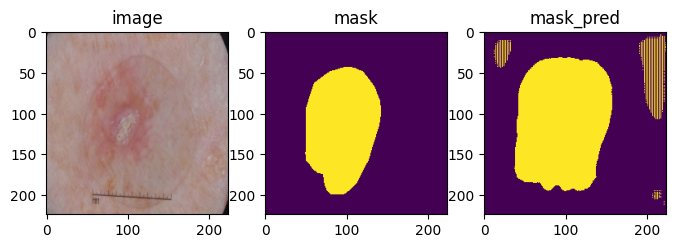

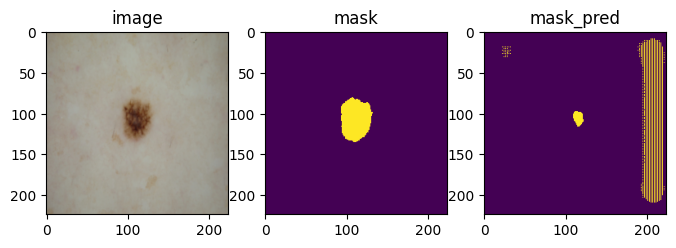

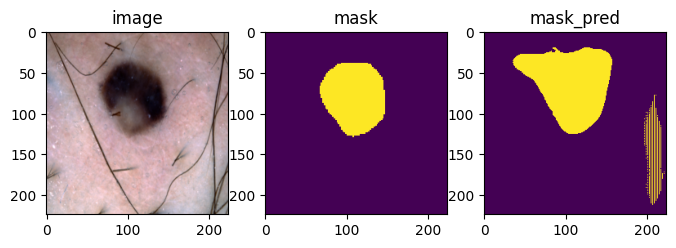

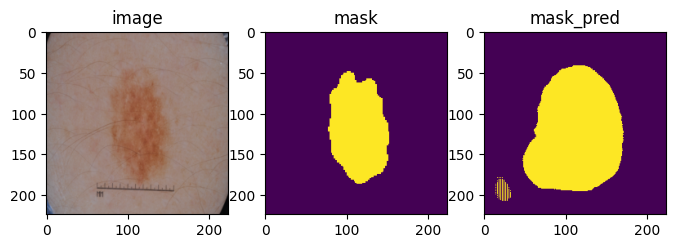

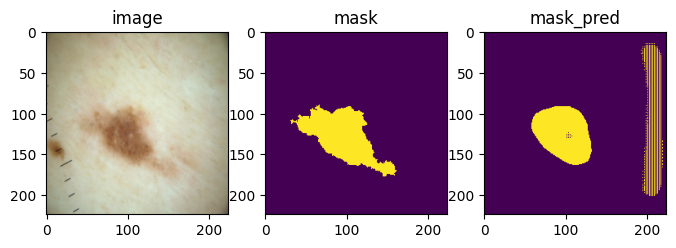

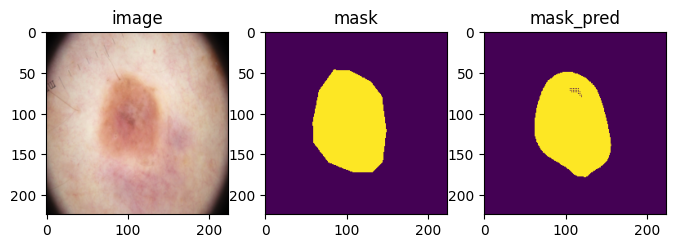

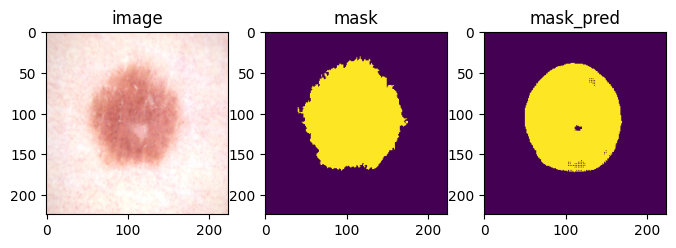

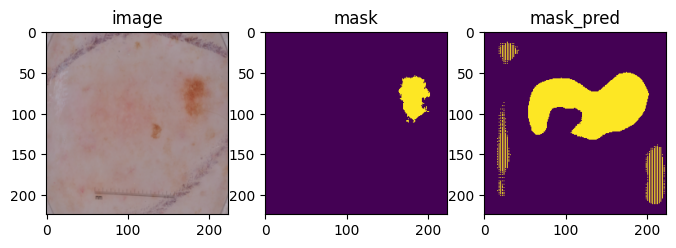

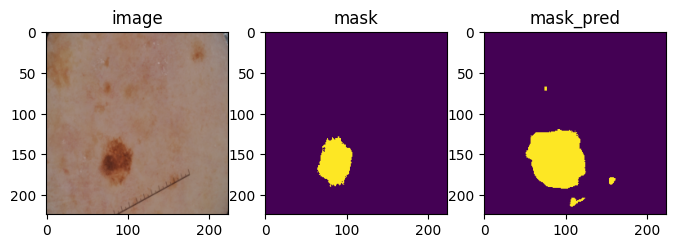

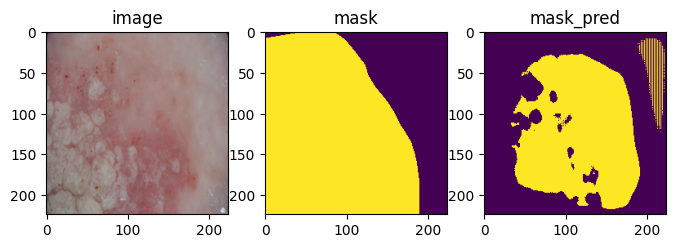

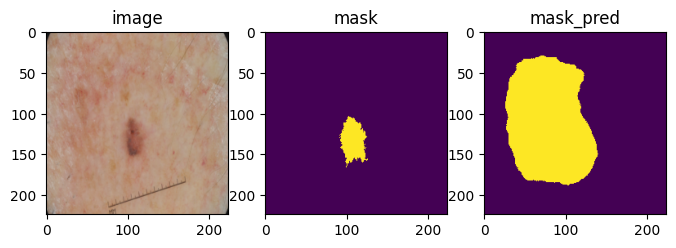

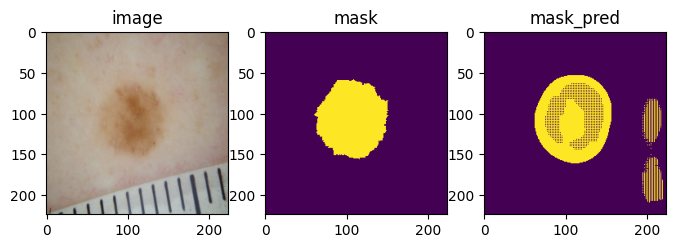

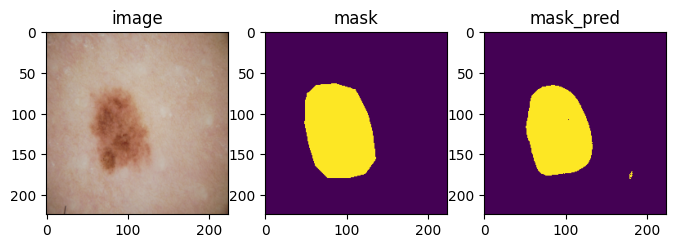

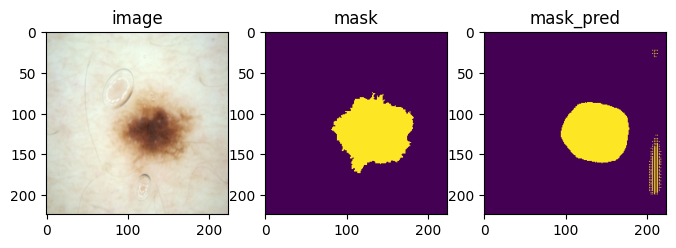

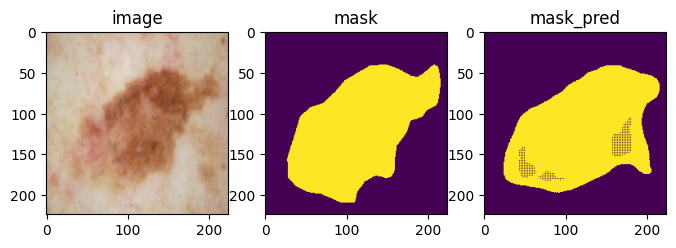

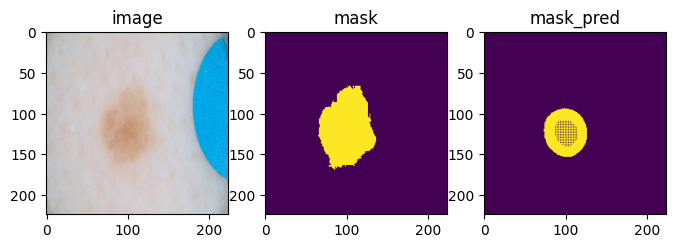

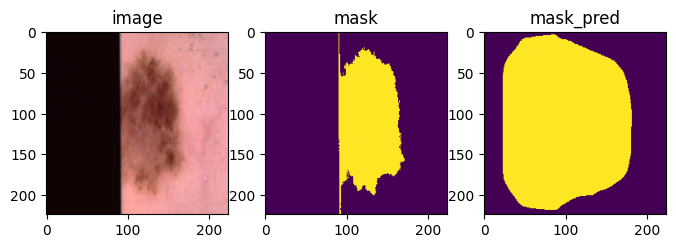

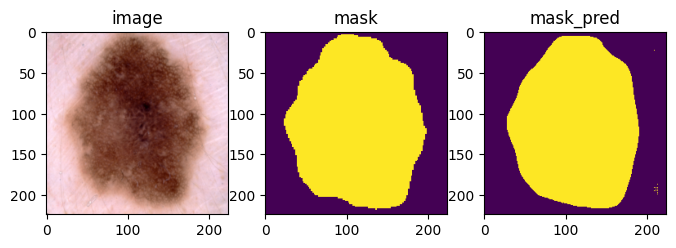

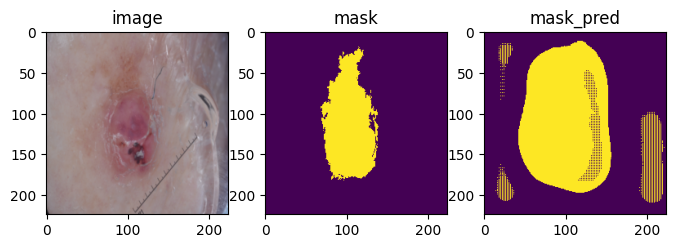

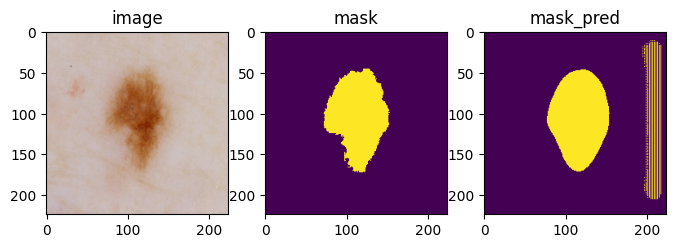

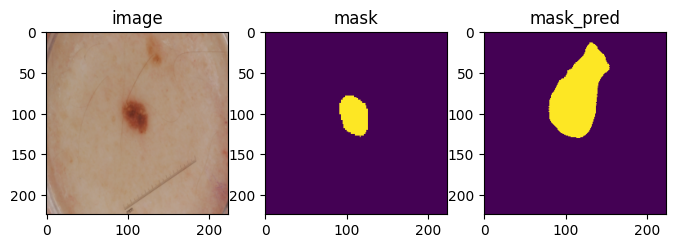

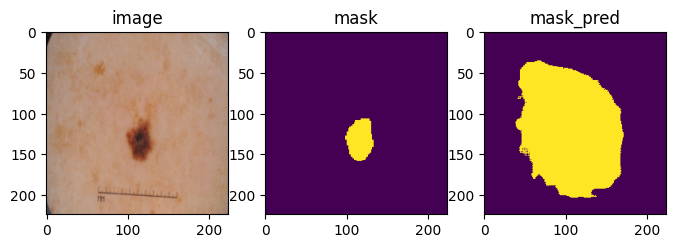

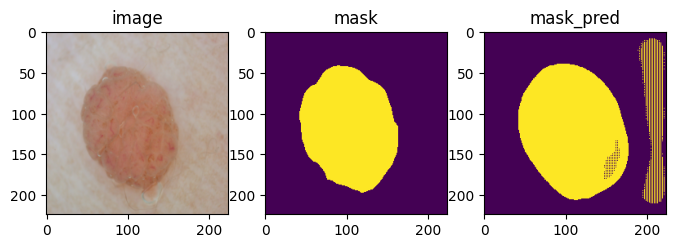

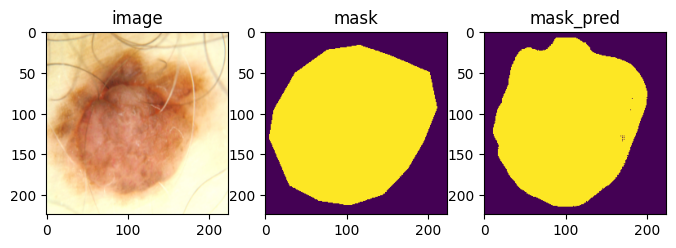

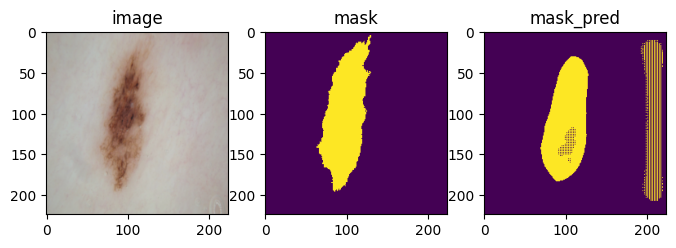

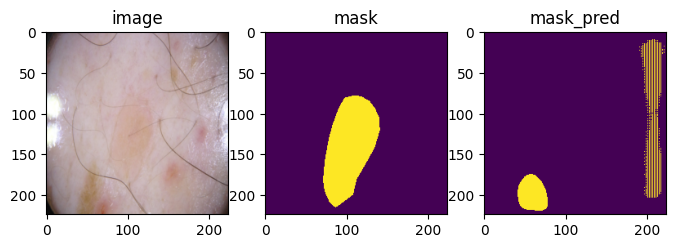

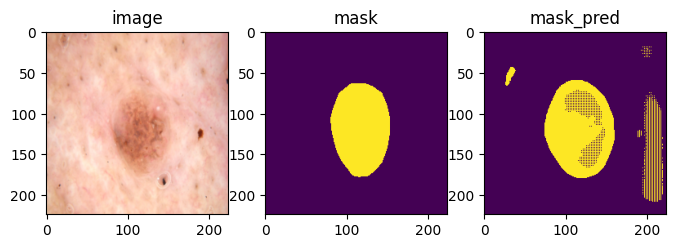

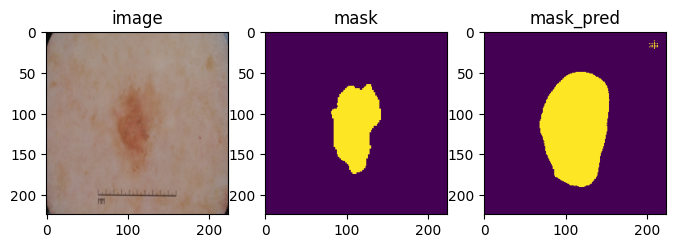

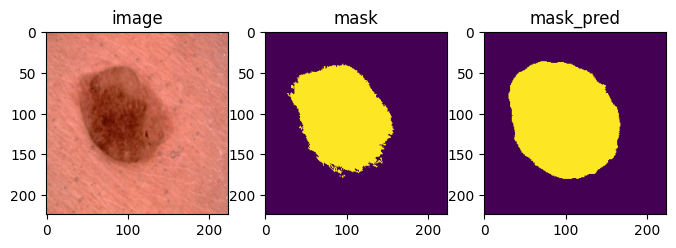

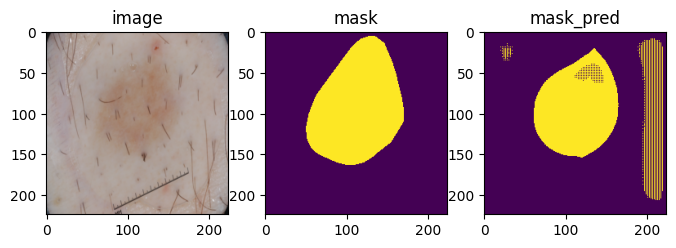

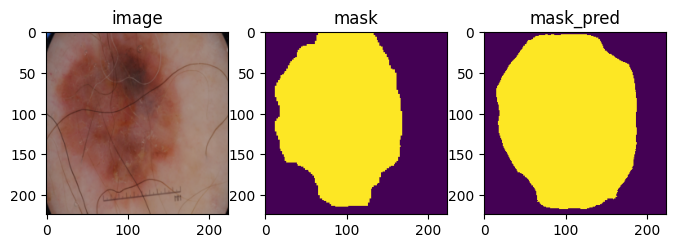

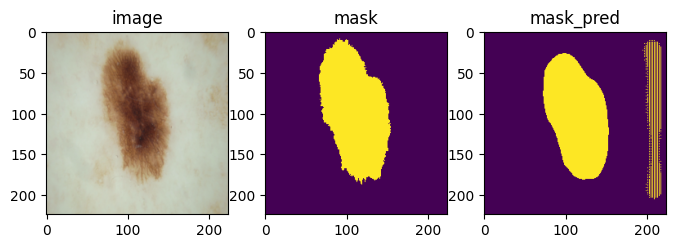

In [ ]:
for i in range(len(image)):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(batch['image'][i].permute((1,2,0)))
    plt.title('image')

    plt.subplot(1, 3, 2)
    plt.imshow(batch['mask'][i])
    plt.title('mask')

    pred = masks_pred[i]
    pred[pred < 0]=0
    pred[pred > 0]=1
    plt.subplot(1, 3, 3)
    plt.imshow(pred)
    plt.title('mask_pred')